In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import os
from itertools import chain
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

from deepthermal.FFNN_model import fit_FFNN, FFNN, init_xavier
from deepthermal.validation import create_subdictionary_iterator, k_fold_cv_grid, add_dictionary_iterators
from deepthermal.plotting import plot_result, plot_model_1d

from neural_reparam.reparametrization import (
    get_elastic_metric_loss,
    compute_loss_reparam,
)
from neural_reparam.ResNet import ResNet
from neural_reparam.models import ResCNN, BResCNN, CNN
from neural_reparam.reinforcement_learning import fit_dqn_deterministic, get_state, is_end_state, get_epsilon_greedy, get_action_map
import experiments.curves as c1

# make reproducible
seed = torch.manual_seed(0)

In [165]:
# Load data
N =32

x_train = torch.linspace(0,1 , N, requires_grad=True)
q_train = c1.q(x_train.unsqueeze(1).detach())
r_train = c1.r(x_train.unsqueeze(1).detach())

data = TensorDataset(x_train, q_train, r_train)


In [166]:
#######
DIR = "../figures/curve_1/"
SET_NAME = "conv_3"
PATH_FIGURES = os.path.join(DIR, SET_NAME)
if not os.path.exists(PATH_FIGURES):
    os.makedirs(PATH_FIGURES)
########


FOLDS = 1
# loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=1e3, verbose=False)
# no_penalty_loss_func = get_elastic_metric_loss(r=c1.r, constrain_cost=0, verbose=False)
depth = 5
num_actions = depth ** 2
MODEL_PARAMS = {
    "model": [FFNN],
    "input_dimension": [2],
    "output_dimension": [num_actions],
    "activation": ["tanh"],
    "n_hidden_layers": [2],
}

# extend the previous dict with the zip of this
MODEL_PARAMS_EXPERIMENT = {
    "neurons": [8],
}
TRAINING_PARAMS = {
    "start_state_index": [torch.LongTensor([0, 0])],
    "get_state": [get_state],
    "choose_action": [get_epsilon_greedy(epsilon=0.2, num_actions=num_actions)],
    "action_map": [get_action_map(depth=depth, data=data)],
    "is_end_state": [is_end_state],
}
# extend the previous dict with the zip of this
TRAINING_PARAMS_EXPERIMENT = {
    "optimizer": ["LBFGS"],
    "num_epochs": [1000],
    "learning_rate": [0.1],
}

In [167]:
# create iterators
model_params_iter_1 = create_subdictionary_iterator(MODEL_PARAMS)
# model_params_iter = chain.from_iterable((model_params_iter_1, model_params_iter_2))

model_exp_iter = create_subdictionary_iterator(MODEL_PARAMS_EXPERIMENT, product=False)
exp_model_params_iter = add_dictionary_iterators(model_exp_iter, model_params_iter_1)

training_params_iter = create_subdictionary_iterator(TRAINING_PARAMS)
training_exp_iter = create_subdictionary_iterator(TRAINING_PARAMS_EXPERIMENT, product=False)
exp_training_params_iter = add_dictionary_iterators(training_exp_iter, training_params_iter)

Do the actual training

In [168]:
cv_results = k_fold_cv_grid(
    model_params=exp_model_params_iter,
    fit=fit_dqn_deterministic,
    training_params=exp_training_params_iter,
    data=data,
    folds=FOLDS,
    verbose=True,
    trials=1
)


Running model (trial=0, mod=0, k=0):
Parameters: ({'model': <class 'deepthermal.FFNN_model.FFNN'>, 'input_dimension': 2, 'output_dimension': 25, 'activation': 'tanh', 'n_hidden_layers': 2, 'neurons': 8}, {'start_state_index': tensor([0, 0]), 'get_state': <function get_state at 0x12da29820>, 'choose_action': <function get_epsilon_greedy.<locals>.epsilon_greedy at 0x12d3fe430>, 'action_map': <function get_action_map.<locals>.action_map at 0x12dc86ee0>, 'is_end_state': <function is_end_state at 0x12da29af0>, 'optimizer': 'LBFGS', 'num_epochs': 1000, 'learning_rate': 0.1})
################################  0  ################################


/usr/local/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


################################  100  ################################
################################  200  ################################
################################  300  ################################
################################  400  ################################
################################  500  ################################
################################  600  ################################
################################  700  ################################
################################  800  ################################
################################  900  ################################


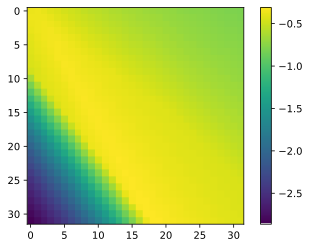

In [169]:
model = cv_results["models"][0][0]
grid = torch.tensor(np.indices((N,N)).T )/(N-1)
result =  torch.min(model(grid).detach(), dim=-1)[0]

# b = plt.imshow(grid.T[0])

# plt.show()
# c = plt.imshow(grid.T[1])
# plt.show()
a = plt.imshow(result.T)
# a = plt.matshow(result)
plt.colorbar(a)
model(torch.tensor([1.,1]))
plt.show()



In [170]:
# plotting

x_train_ = x_train.detach()
x_sorted, indices = torch.sort(x_train_, dim=0)
plot_kwargs = {
    "x_test": x_sorted,
    "x_train": x_sorted,
    "y_train": c1.ksi(x_sorted),
    "x_axis": "t",
    "y_axis": "$\\varphi(t)$",
    "compare_label": "Analytical solution"
}
plot_result(
    path_figures=PATH_FIGURES,
    **cv_results,
    plot_function=plot_model_1d,
    function_kwargs=plot_kwargs,
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 2x8)

In [ ]:


models = cv_results["models"]

parameters = np.vectorize(lambda model: sum(p.numel() for p in model.parameters()))(models).flatten()
model_type = np.vectorize(str)(models).flatten()
layers = np.vectorize(lambda model: model.n_hidden_layers)(models).flatten()
neurons = np.vectorize(lambda model: model.neurons)(models).flatten()
# loss_array = np.vectorize(lambda model: no_penalty_loss_func(model, x_train, q_train).detach())(models).flatten()

kernel_size = np.vectorize(lambda model: model.kernel_size if isinstance(model, CNN) else 0)(models).flatten()

# make data frame
d_results = pd.DataFrame(
    {"loss": loss_array, "neurons": neurons, "layers": layers, "parameters": parameters, "model": model_type,
     "kernel_size": kernel_size})

d_results_layer = d_results[d_results.neurons == 8]
d_results_neurons = d_results[d_results.layers == 2]

In [ ]:
fig_neurons = sns.lineplot(data=d_results_neurons, y="loss", x="neurons", hue="model", ci=80, err_style="bars")
fig_neurons.set(xscale="log", yscale="log", xlabel="Neurons")
fig_neurons.set(ylabel="$E$")
plt.savefig(f"{PATH_FIGURES}/neurons_error.pdf")
plt.show()


In [ ]:
print("faled, total:")
print(len(d_results_neurons[d_results_neurons.loss > 1]), len(d_results_neurons))

In [ ]:
fig_layers = sns.lineplot(data=d_results_layer, y="loss", x="layers", hue="model", ci=80, err_style="bars")
fig_layers.set(yscale="log", xscale="log", xlabel="Hidden layers", ylabel="Error")
fig_layers.set(ylabel="$E$")
plt.savefig(f"{PATH_FIGURES}/layer_error.pdf")
plt.show()


In [ ]:
print("faled, total:")
print(len(d_results_layer[d_results_layer.loss
                          > 1]), len(d_results_layer))

In [ ]:
fig_scatter = sns.scatterplot(data=d_results, y="loss", x="parameters", hue="model")
fig_neurons.set(ylabel="$E$")
fig_scatter.set(yscale="log")
plt.show()

In [ ]:
print(len(d_results[d_results.loss < 10]), len(d_results))

In [ ]:
d_results.to_csv(f"{PATH_FIGURES}/d_results.csv")


In [ ]:
d_results

In [ ]:
model = cv_results["models"][0][0]
model

FFNN(
  (activation_): Tanh()
  (input_layer): Linear(in_features=2, out_features=8, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (output_layer): Linear(in_features=8, out_features=25, bias=True)
)